### Import data

In [2]:
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import os.path
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import minimize
from DATA import get_filtered_stock_data as gfs
from DATA import read_data
from DATA import delete_pickle_file
from Effient_Frontier import get_cov_mean_matrices
from Effient_Frontier import efficient_frontier

In [7]:
delete_pickle_file('ESG_US.csv.pickle')

File 'ESG_US.csv.pickle' has been deleted.


In [3]:
#stock_data = None
file_path = "ESG_DATA.csv"
esg = read_data(file_path)
column_name = 'environment_level'
column_value = 'High'
threshold = None
operator = 'geq'
prefixes= ['US']
start_date = '2015-01-01'
end_date = '2021-04-30'

In [4]:
returns = gfs(file_path, column_name, column_value, prefixes, start_date, end_date, time='y', threshold=threshold, operator=operator)

In [8]:
mu = get_cov_mean_matrices(returns)[1]
cov = get_cov_mean_matrices(returns)[0]
esg = read_data(file_path)
target = np.linspace(np.min(mu), np.max(mu), 100)
rf = 0.00
bounds = [(0, 1) for _ in range(len(mu))]
score = 'environment_score'

In [9]:
eff = efficient_frontier(mu, cov, target, rf, bounds, esg, returns, score)

In [10]:
max_sharpe_ret = eff[0]
max_sharpe_vol = eff[1]
max_sharpe_sr = eff[2]
portfolio_esg = eff[3]
print(portfolio_esg)
fron=eff[4]
mu = eff[5]
stdevs_ = eff[6]

[511.33181375234545]


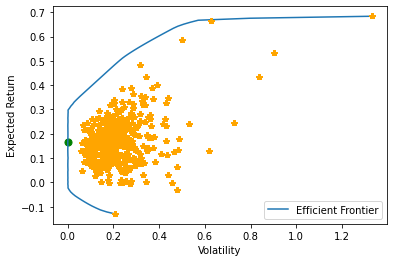

In [11]:
# Plot the efficient frontier and Sharpe ratio
plt.plot(fron[:,1], fron[:,0], label='Efficient Frontier')
plt.plot(stdevs_, mu, '*', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()

# Plot a red dot at the portfolio with the highest Sharpe ratio
plt.scatter(max_sharpe_vol, max_sharpe_ret, marker='o', color='g', s=50, label='Max Sharpe Ratio')
plt.show()

Text(0, 0.5, 'Sharpe Ratio')

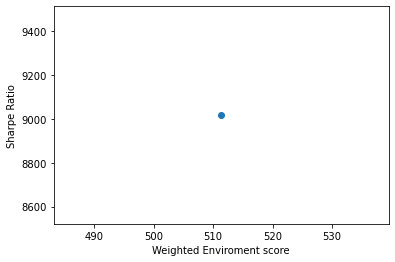

In [12]:
plt.scatter(portfolio_esg, max_sharpe_sr)
plt.xlabel('Weighted Enviroment score')
plt.ylabel('Sharpe Ratio')

#### Martin kode

In [ ]:
def check_for_zeros(df):
    # Check if any element in the DataFrame is equal to 0
    if (df == 0).any().any():
        print("There are 0's in the DataFrame.")
    else:
        print("There are no 0's in the DataFrame.")

def has_infinite(df):
    """
    Returns True if the DataFrame contains any infinite value, otherwise False.
    """
    return not np.isfinite(df).all().all()

In [ ]:
check_for_zeros(returns.cov())
has_infinite(returns.cov())

In [60]:
mean_matrix = np.array(returns.mean())
cov_matrix = np.array(returns.cov())
#print(cov_matrix )


# Permanently changes the pandas settings
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)
 
# All dataframes hereafter reflect these changes.
#display(returns.cov())
#display(returns.mean())
 
# Resets the options
#pd.reset_option('all')


-6.01249422243008e+17
7336659488206958.0
-9916450511414772.0
5.908433568243615e+33


C:\Users\Bruger\AppData\Local\Temp\ipykernel_14752\230930840.py:26: RuntimeWarning: invalid value encountered in sqrt
  minstd = np.sqrt(minvar)


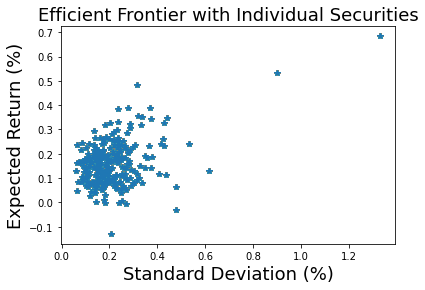

In [62]:
#S = np.array([[185, 86.5, 80, 20],[86.5, 196, 76, 13.5],[80, 76, 411, -19],[20, 13.5, -19, 25]])*100
S = cov_matrix
#zbar = np.array([14, 12, 15, 7])
zbar = mean_matrix
unity = np.ones(len(zbar))

# Calculate standard deviations of securities
stdevs = np.sqrt(np.diag(S))

# Calculate parameters A, B, C, and D for efficient frontier
A = np.dot(unity.T, np.dot(np.linalg.inv(S), unity))
print(A)
B = np.dot(unity.T, np.dot(np.linalg.inv(S), zbar))
print(B)
C = np.dot(zbar.T, np.dot(np.linalg.inv(S), zbar))
print(C)
D = A*C - B**2
print(D)

# Define mu values for efficient frontier
mu = np.linspace(np.min(zbar), np.max(zbar), 100)

# Calculate minimum variance and standard deviation for each mu
minvar = ((A * mu ** 2) - 2 * B * mu + C) / D
# minvar[minvar < 0] = 0    # Ensure minvar is non-negative
minstd = np.sqrt(minvar)

# Repeat stdevs and zbar 300 times to match length of mu and minstd
stdevs_ = np.repeat(stdevs[:, np.newaxis], 100, axis=1)
zbar_ = np.repeat(zbar[:, np.newaxis], 100, axis=1)

# Plot efficient frontier and individual securities
plt.plot(minstd, mu, label='Efficient Frontier')
plt.plot(stdevs_, zbar_, '*', label='Individual Securities')
#plt.legend()
plt.title('Efficient Frontier with Individual Securities', fontsize=18)
plt.ylabel('Expected Return (%)', fontsize=18)
plt.xlabel('Standard Deviation (%)', fontsize=18)
plt.show()

In [ ]:
np.linalg.inv(S)

In [ ]:
# Define the expected returns and covariance matrix of the assets
mu = mean_matrix
cov = cov_matrix

# Define the objective function to minimize
def objective(weights):
    return np.dot(weights.T, np.dot(cov, weights))

# Define the constraint that the sum of the weights equals 1
def constraint(weights):
    return np.sum(weights) - 1

# Define the bounds for the weights
bounds = [(0, 1) for _ in range(len(mu))]

# Define the risk-free rate
rf = 0

# Define the range of returns to plot
target = np.linspace(np.min(mu), np.max(mu), 100)

#negative sharpe ratio calculator
def negativeSR(w):
    w = np.array(w)
    V = np.sqrt(w.T @ cov @ w)
    R = np.sum(mu *w)
    SR = (R-rf)/V
    return -1*SR

# Define the initial guess for the weights
x0 = np.ones(len(mu)) / len(mu)

# Calculate the efficient frontier
frontier = []
portfolio_esg = []
#weights_list = []
for ret in target:
    # Define the constraint that the expected return of the portfolio equals the desired return
    def ret_constraint(weights):
        return np.dot(weights, mu) - ret
    # Use the minimize function to find the portfolio weights that minimize the objective function subject to the constraints
    res = minimize(objective, x0, method='SLSQP', constraints=[{'type': 'eq', 'fun': constraint}, {'type': 'eq', 'fun': ret_constraint}], bounds=bounds)
    # Calculate the volatility of the portfolio
    #weights_list.append(res.x)
    vol = np.sqrt(res.fun)
    # Calculate the Sharpe ratio of the portfolio
    sharpe = (ret - rf) / vol
    # Append the results to the frontier
    frontier.append((ret, vol, sharpe))

# Convert the frontier to a numpy array
frontier = np.array(frontier)

#find sharpe ratio weights
constraints = ({'type': 'eq', 'fun': constraint})
w_opt = minimize(negativeSR,x0,method='SLSQP',bounds=bounds,constraints=constraints).x



result = 0
for count, col in enumerate(returns.columns):
    #print(type(col))
    first = esg[esg['Isin']==col]
    env = first['environment_score']
    env = env.to_numpy()[0]
    result += w_opt[count] * env

# Find the portfolio with the highest Sharpe ratio
max_sharpe_idx = np.argmax(frontier[:,2])
max_sharpe_ret, max_sharpe_vol, max_sharpe_sr = frontier[max_sharpe_idx]



# Calculate standard deviations of securities
stdevs = np.sqrt(np.diag(cov))
stdevs_ = np.repeat(stdevs[:, np.newaxis], 100, axis=1)
mu = np.repeat(mu[:, np.newaxis], 100, axis=1)

# Plot the efficient frontier and Sharpe ratio
plt.plot(frontier[:,1], frontier[:,0], label='Efficient Frontier')
plt.plot(stdevs_, mu, '*', color='orange')#label='Individual Securities')
#plt.scatter(frontier[:,1], frontier[:,0], c=frontier[:,2]), cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
#plt.colorbar(label='Sharpe Ratio')
plt.legend()

# Plot a red dot at the portfolio with the highest Sharpe ratio
plt.scatter(max_sharpe_vol, max_sharpe_ret, marker='o', color='g', s=50, label='Max Sharpe Ratio')

plt.show()

In [ ]:
 res

In [ ]:
test = esg[esg['Isin']=='SE0011337708']
test = test['environment_score']
test = test.to_numpy()[0]
test


### TEST

In [18]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [22]:
# Calculate expected returns and sample covariance
mu = np.array(returns.mean())
S = np.array(returns.cov())

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([(0, 0.00017), (1, 0.00032), (2, 0.00033), (3, 0.0), (4, 0.00017), (5, 0.00013), (6, 0.00021), (7, 0.14761), (8, 0.00236), (9, 0.00018), (10, 0.00025), (11, 0.00029), (12, 0.00032), (13, 0.00054), (14, 0.00018), (15, 0.00024), (16, 0.00012), (17, 0.00026), (18, 0.00032), (19, 0.00073), (20, 0.0), (21, 0.00059), (22, 0.00033), (23, 0.00052), (24, 0.00012), (25, 0.00012), (26, 0.00035), (27, 0.00066), (28, 0.00026), (29, 0.0), (30, 0.00021), (31, 0.00017), (32, 0.00026), (33, 0.00045), (34, 0.0007), (35, 0.00028), (36, 0.0), (37, 0.00021), (38, 0.00012), (39, 0.00058), (40, 0.0), (41, 0.00014), (42, 0.00023), (43, 0.00045), (44, 0.00032), (45, 0.00042), (46, 0.00077), (47, 0.00012), (48, 0.0), (49, 0.00017), (50, 0.00039), (51, 0.00021), (52, 0.00016), (53, 0.00021), (54, 0.00299), (55, 0.00059), (56, 0.00031), (57, 0.0093), (58, 0.00019), (59, 0.0), (60, 0.00041), (61, 0.0003), (62, 0.0003), (63, 0.00022), (64, 0.0), (65, 0.00026), (66, 0.00022), (67, 0.00046), (68, 0.00027)

C:\Users\Bruger\anaconda3\lib\site-packages\pypfopt\base_optimizer.py:556: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(objective_functions.portfolio_variance(new_weights, cov_matrix))
C:\Users\Bruger\anaconda3\lib\site-packages\cvxpy\atoms\elementwise\power.py:181: RuntimeWarning: invalid value encountered in power
  return np.power(values[0], float(self.p.value))


(0.020014123976906696, nan, nan)